#Imports et utilitaires

In [ ]:
!pip install -q gcsfs shap optuna

import optuna
import pandas as pd, numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from graphviz import Source
from IPython.display import SVG
%matplotlib inline

#dessine la graphe d'Elbow pour trouver le nombre idéal de clusters 
def findbestclusters(data,maxclusters=30,minclusters=2):
  Sum_of_squared_distances = []
  K = range(minclusters,maxclusters)
  for k in K:
      km = KMeans(n_clusters=k, random_state=49)
      km = km.fit(data)
      Sum_of_squared_distances.append(km.inertia_)
  plt.plot(K, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

  sil = []
  # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
  for k in range(minclusters+1, maxclusters+1):
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    sil.append({'k':k,'score':silhouette_score(X, labels, metric = 'euclidean')})
  sil=pd.DataFrame(sil)
  sil.plot(x='k',y='score')
  return sil[sil.score==sil.score.max()].iloc[0,0]

target='PERFORMANCE: resultat par uth familial'

     |████████████████████████████████| 327kB 3.9MB/s 
     |████████████████████████████████| 235kB 7.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2MB 12.1MB/s 
     |████████████████████████████████| 92kB 8.1MB/s 
     |████████████████████████████████| 163kB 13.0MB/s 
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 266kB 17.3MB/s 
     |████████████████████████████████| 153kB 19.4MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 112kB 20.7MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 133kB 17.0MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



#Préparation de données

##p

In [ ]:
!gsutil cp gs://referentiels2/viande.csv .
viande=pd.read_csv('viande.csv').dropna()
viande['ID_Dossier']=viande['ID_Dossier'].astype(int)
viande['DEP']=viande['DEP'].astype(int)
df=pd.read_csv('gs://referentiels2/laitratios.csv',sep=';')
df=df.merge(viande, how='left')
df['Produit_vente_animaux']=df['Produit_vente_animaux'].fillna(0)
df.to_csv('gs://referentiels2/laitratios1.csv',index=False)

Copying gs://referentiels2/viande.csv...
/ [1 files][505.5 KiB/505.5 KiB]                                                
Operation completed over 1 objects/505.5 KiB.                                    


In [ ]:
lait=pd.read_csv('gs://referentiels2/lait.csv',sep=';')
!gsutil cp gs://referentiels2/viande.csv .
viande=pd.read_csv('viande.csv').dropna()
viande['ID_Dossier']=viande['ID_Dossier'].astype(int)
viande['DEP']=viande['DEP'].astype(int)
lait=lait.merge(viande, how='left')
lait['PB_VEG']=lait['PRODUIT_BRUT']-lait['PRODUIT_LAIT_VALEUR_TOTALE']-lait['Produit_vente_animaux'].fillna(0)-lait['AUTRES_PRODUITS']
#PRODUIT BRUT – VENTES LAIT – VENTES ANIMAUX – AUTRES PRODUITS = PB_VEG.


Copying gs://referentiels2/viande.csv...
/ [1 files][505.5 KiB/505.5 KiB]                                                
Operation completed over 1 objects/505.5 KiB.                                    


In [ ]:
lait['PB_VEG_VLAIT']=lait['PB_VEG']/lait['PRODUIT_LAIT_QUANTITE']

In [ ]:
df=pd.read_csv('gs://referentiels2/laitratios1.csv')

In [ ]:
df=df.merge(lait[['DEP','ID_Dossier','Annee','PB_VEG_VLAIT']], how='left')

In [ ]:
df['PB_VEG_VLAIT']=df['PB_VEG_VLAIT'].fillna(0)

In [ ]:
lait['PRODUIT_BRUT_HA']=lait.PRODUIT_BRUT/lait['TOTAL_SAU']

In [ ]:
lait['VLAIT_HA']=lait['PRODUIT_LAIT_QUANTITE']/lait['TOTAL_SAU']

In [ ]:
df=df.merge(lait[['DEP','ID_Dossier','Annee','PRODUIT_BRUT_HA','VLAIT_HA']], how='left')

In [ ]:
df.to_csv('gs://referentiels2/laitratios1.csv',index=False)

In [ ]:
c=pd.read_csv('correctionnord.csv')

In [ ]:
c=c[c.DEP.isin(['59','62'])]

In [ ]:
c['DEP']=c['DEP'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df=pd.read_csv('gs://referentiels2/laitratios1.csv')

In [ ]:
df=df.merge(c, how='left', on=['DEP','ID_Dossier','Annee'])

In [ ]:
df['VLAIT_PAR_UGB_VL']=np.where(df['VLAIT_PAR_UGB_VL_y'].isna(),df['VLAIT_PAR_UGB_VL_x'],df['VLAIT_PAR_UGB_VL_y'])

In [ ]:
df.drop(['VLAIT_PAR_UGB_VL_y','VLAIT_PAR_UGB_VL_x'],1,inplace=True)

In [ ]:
df.to_csv('gs://referentiels2/laitratios1.csv',index=False)

##ajout du lait par sau et sfp

In [ ]:
lait=pd.read_csv('gs://referentiels2/lait.csv',sep=';')
complements=lait[['DEP','ID_Dossier','Annee','PRODUIT_LAIT_QUANTITE','TOTAL_SAU','SFP']].copy()
complements['lait_par_sau']=complements.PRODUIT_LAIT_QUANTITE/complements.TOTAL_SAU
complements['lait_par_sfp']=complements.PRODUIT_LAIT_QUANTITE/complements.SFP
complements=complements[['DEP','ID_Dossier','Annee','lait_par_sau','lait_par_sfp']].copy()
df=pd.read_csv('gs://referentiels2/laitratios1.csv')
df=df.merge(complements, how='left')
df.to_csv('gs://referentiels2/laitratios1.csv',index=False)

#Nettoyage des valeurs extrêmes et remplacement des valeurs manquantes

In [ ]:
df=pd.read_csv('/content/BASE_ALL_PROJET_LAIT_VF_23032020.csv',sep=';')
df=df[df['SFP']>0]
df=df[df['VLAIT_PAR_VL']!='#DIV/0!']
df['VLAIT_PAR_VL']=df['VLAIT_PAR_VL'].astype(float)
df['POSITIONNEMENT: lait par ha de surface fourragère principale']=df['PRODUIT_LAIT_QUANTITE']/df['SFP']
df=df.rename(columns={'PRODUIT_BRUT_HA':'PRATIQUES D\'ELEVAGE: produit brut par hectare','PB_VEG_VLAIT':'PRATIQUES D\'ELEVAGE: ventes de végétaux','DEP':'ID: département','ID_Dossier':'ID: dossier','RESULTAT_PAR_UTH_FAM':'CIBLE: resultat par uth familial','UTH_FAMILIAUX':'DIMENSION: uth familiaux','TOTAL_ANNUITES_VLAIT':'DYNAMIQUE STRUCTURELLE: annuites','AUTRES_FRAIS_ELEVAGE_VLAIT':'PRATIQUES D\'ELEVAGE: autres frais','CHARGES_FINANCIERES_CT_VLAIT':'DYNAMIQUE STRUCTURELLE: charges financières court terme',
                  'CHARGES_FINANCIERES_LMT_VLAIT':'DYNAMIQUE STRUCTURELLE: charges financières long terme','HONORAIRES_VETO_PAR_VLAIT':'PRATIQUES D\'ELEVAGE: frais vétérinaires','SALAIRES_CHARGES_SOCIALES_VLAIT':'DYNAMIQUE STRUCTURELLE: salaires chargés',
                   'VLAIT_PAR_UTH_FAM':'DYNAMIQUE STRUCTURELLE: volume de lait par uth familial','SURFACE_MAIS_FOURRAGER':'DIMENSION: surface de maïs fourrager',
                   'TOTAL_CHARGES_STRUCTURE_VLAIT':'DYNAMIQUE STRUCTURELLE: charges de structure',
                   'UGB':'DIMENSION: taille du troupeau','VLAIT_PAR_VL':'POSITIONNEMENT: lait par vache laitière',
                   'Produit_vente_animaux':'PRATIQUES D\'ELEVAGE: vente d\'animaux','TAUX_SPECIALISATION':'PRATIQUES D\'ELEVAGE: taux de spécialisation','PRIX_UNITAIRE_LAIT':'INVARIANT: prix du lait','SFP':'DIMENSION: surface des prairies',
                   'CHARGES_ALIMENTS_PAR_VLAIT':'PRATIQUES D\'ELEVAGE: aliments','PRODUIT_BRUT_VLAIT':'PRATIQUES D\'ELEVAGE: produit brut',
                   'AMORTISSEMENTS_VLAIT':'DYNAMIQUE STRUCTURELLE: amortissements',
                   })

orders=['ID','INVARIANT','DIMENSION','DYNAMIQUE STRUCTURELLE','PRATIQUES D\'ELEVAGE','POSITIONNEMENT','CIBLE']
df=pd.concat([df.filter(regex=f'{order}:') for order in orders],1)
df=df.fillna(0)

#sélection des fermes avec 3 exercices minimum et moyenne des valeurs
indexcolumns=list(df.filter(regex='ID:').columns)
means=df.groupby(indexcolumns).mean()
counts=df.groupby(indexcolumns).count().iloc[:,0]
counts=counts[counts>2]
df=means[means.index.isin(counts.index)]
df=df[(df['POSITIONNEMENT: lait par ha de surface fourragère principale']<20000) & (df['POSITIONNEMENT: lait par vache laitière']>4000) & (df['POSITIONNEMENT: lait par vache laitière']<20000) & (df['DIMENSION: surface des prairies']<200) & (df['DIMENSION: taille du troupeau']<400) & (df['CIBLE: resultat par uth familial']>-20000)]

In [ ]:
df.shape #814 737

(737, 20)

#détermination des groupes

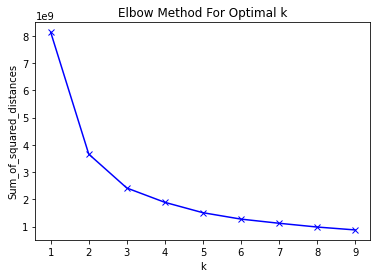

NameError: ignored

In [ ]:
n_clusters=findbestclusters(df.filter(regex='POSITIONNEMENT'),maxclusters=10,minclusters=1)

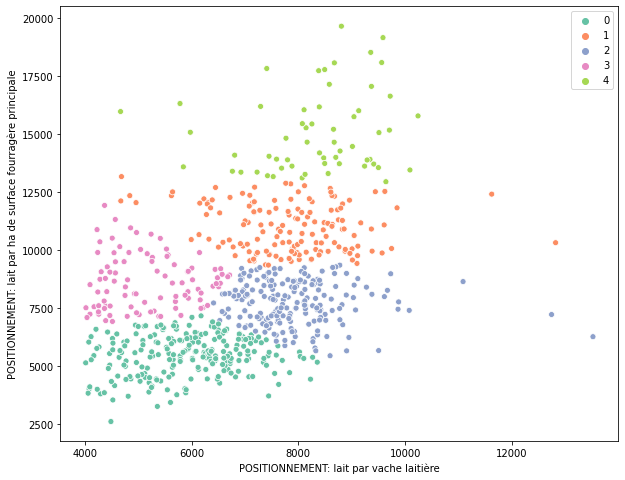

In [ ]:
n_clusters=5
km = KMeans(n_clusters=n_clusters, random_state=49)
y=km.fit_predict(df.filter(regex='POSITIONNEMENT'))
fig, ax = plt.subplots(figsize=(10,8)) 
sns.scatterplot(data=df, x='POSITIONNEMENT: lait par vache laitière',y='POSITIONNEMENT: lait par ha de surface fourragère principale',hue=y,ax=ax,palette="Set2",)

In [ ]:
dfclustered=df.copy()
dfclustered['cluster']=y
dfclustered.to_csv('gs://referentiels2/dfclustered.csv')

In [ ]:
dfclustered

INVARIANT: prix du lait  ...  cluster
ID: département ID: dossier                           ...         
27              271000411                 333.896882  ...        0
                272000696                 361.467923  ...        3
                272001350                 342.488599  ...        3
                272001507                 328.079034  ...        4
                272001793                 363.428486  ...        3
...                                              ...  ...      ...
80              89839                     334.252259  ...        4
                90118                     329.786950  ...        2
                90829                     338.476554  ...        4
                91314                     340.895702  ...        1
                91504                     335.542350  ...        4

[737 rows x 21 columns]

In [ ]:
import plotly.express as px
fig = px.scatter_3d(dfclustered, x='POSITIONNEMENT: lait par vache laitière',y='POSITIONNEMENT: lait par ha de surface fourragère principale', z='CIBLE: resultat par uth familial',
              color='cluster')
fig.show()

In [ ]:
dfclustered.to_csv('dfclustered.csv')

#détermination des critères de clusters

In [ ]:
dfclustered=pd.read_csv('gs://referentiels2/dfclustered.csv')

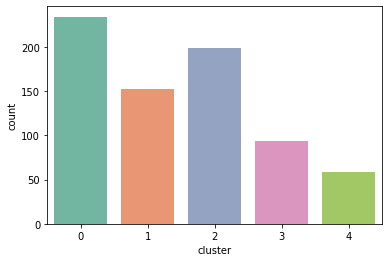

In [ ]:
sns.countplot(x='cluster',data=dfclustered, palette='Set2')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



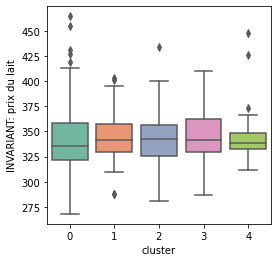

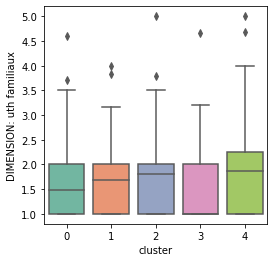

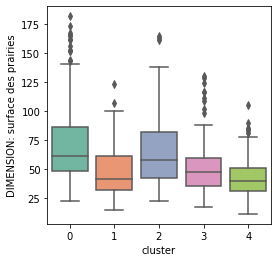

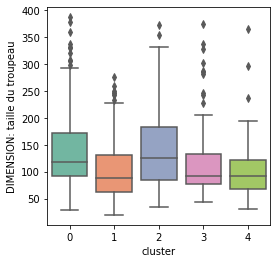

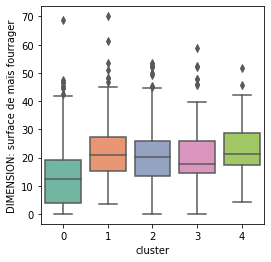

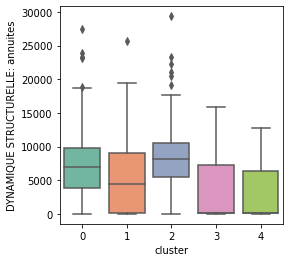

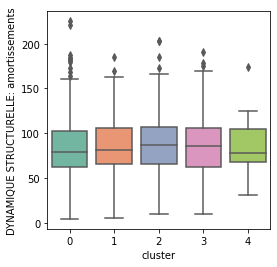

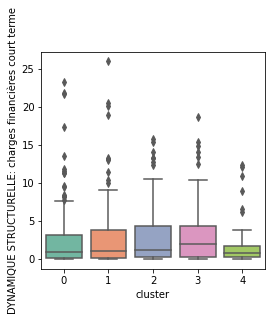

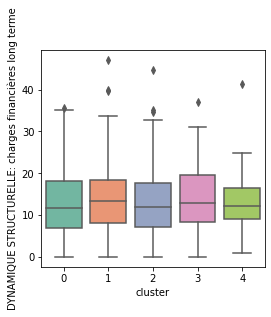

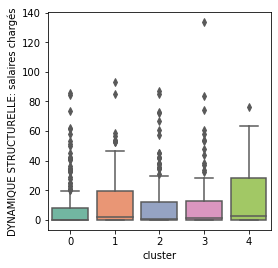

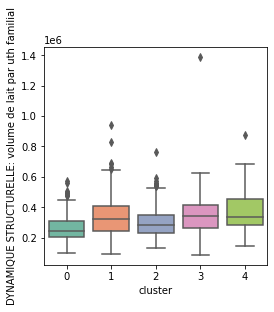

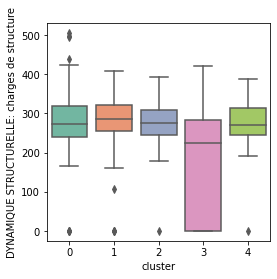

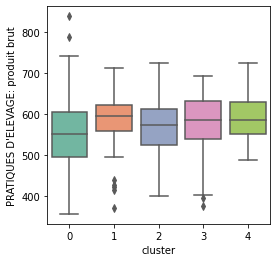

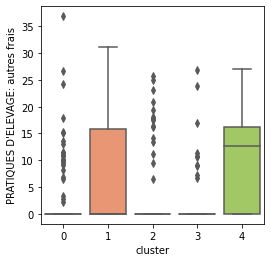

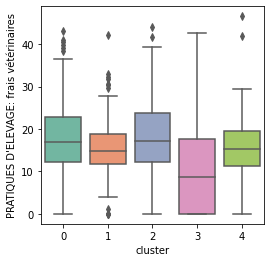

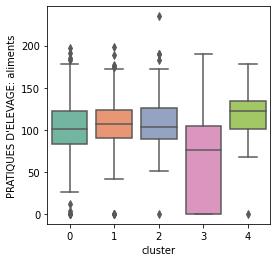

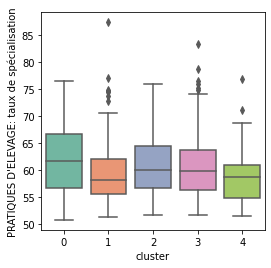

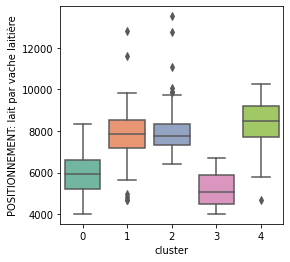

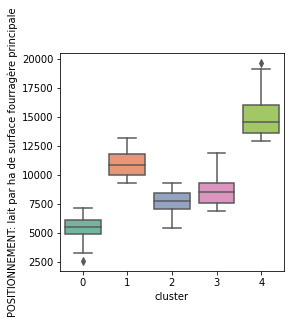

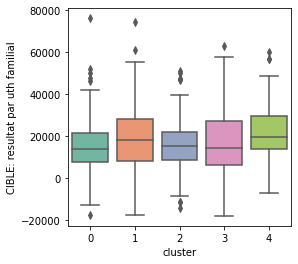

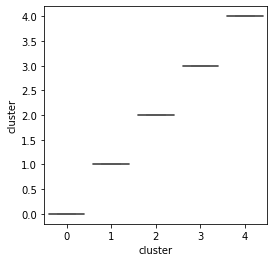

In [ ]:
for c in dfclustered.columns:
  fig, ax = plt.subplots(figsize=(4,4)) 
  sns.boxplot(x="cluster", y=c, data=dfclustered,
                   ax=ax, palette='Set2')

In [ ]:
dfclustered

INVARIANT: prix du lait  ...  cluster
ID: département ID: dossier                           ...         
27              271000411                 333.896882  ...        0
                272000696                 361.467923  ...        3
                272001350                 342.488599  ...        3
                272001507                 328.079034  ...        4
                272001793                 363.428486  ...        3
...                                              ...  ...      ...
80              89839                     334.252259  ...        4
                90118                     329.786950  ...        2
                90829                     338.476554  ...        4
                91314                     340.895702  ...        1
                91504                     335.542350  ...        4

[737 rows x 21 columns]

In [ ]:
import plotly.graph_objects as go
values=dfclustered.groupby('cluster').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
for cluster in dfclustered.cluster.unique():
  print(cluster)
  cluster0=dfclustered.copy()
  cluster0['cluster']=cluster0['cluster']==cluster
  cluster0=cluster0.drop(['ID: dossier','ID: département','POSITIONNEMENT: lait par ha de surface fourragère principale','POSITIONNEMENT: lait par vache laitière'],1)
  X=cluster0.drop('cluster',1)
  y=cluster0.cluster
  estimator = DecisionTreeClassifier(max_depth=3)
  estimator.fit(X, y)

  graph = Source(tree.export_graphviz(estimator, out_file=None
    , feature_names=X.columns
    , filled = True))
  display(SVG(graph.pipe(format='svg')))

#analyse suite

In [ ]:
import lightgbm as lgb
import shap
dfclustered=pd.read_csv('gs://referentiels2/dfclustered.csv')
def bestandworst(cluster):
  c0=dfclustered[dfclustered.cluster==cluster].drop(['cluster','x','y'],1).set_index(['ID: département','ID: dossier','ID: année'])
  random_state = 7
  X = c0.drop('PERFORMANCE: resultat par uth familial',1)
  y=c0['PERFORMANCE: resultat par uth familial']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
  model=lgb.LGBMRegressor(n_estimators=50000)
  model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20,verbose=False)
  explainer = shap.TreeExplainer(model)
  expected_value = explainer.expected_value
  features = X.loc[y.sort_values()[-20:].append(y.sort_values()[:20]).index]
  features_display = features
  shap_values = explainer.shap_values(features)#[1]
  shap_interaction_values = explainer.shap_interaction_values(features)
  shap.decision_plot(expected_value, shap_values, features_display)
  #shap.summary_plot(shap_values, X)

In [ ]:
dfclustered.to_csv('dfclustered.csv',index=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


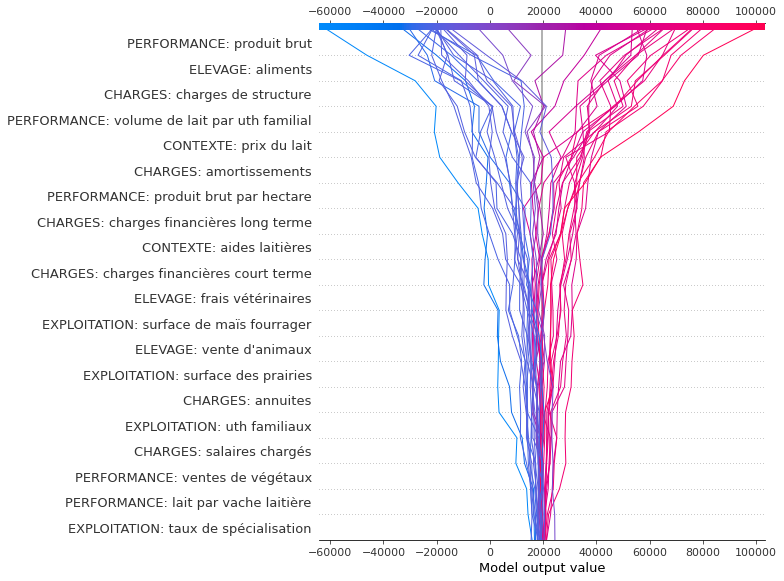

In [ ]:
bestandworst(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


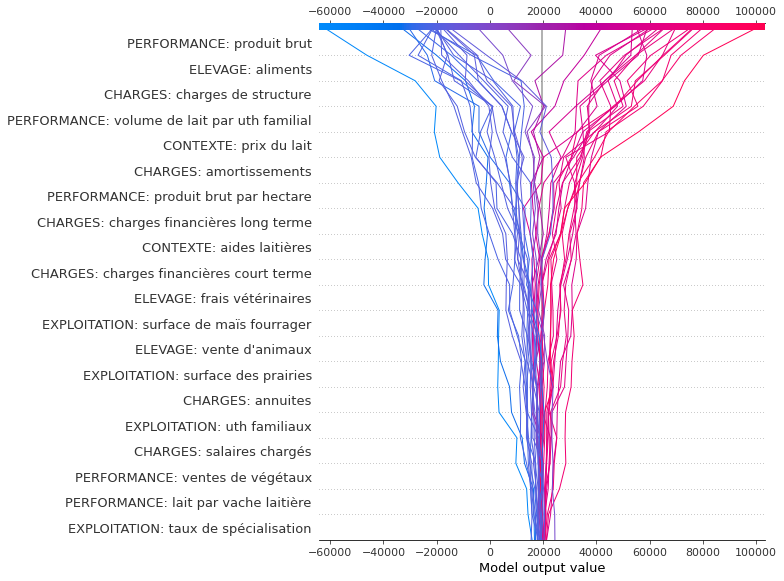

In [ ]:
bestandworst(0)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


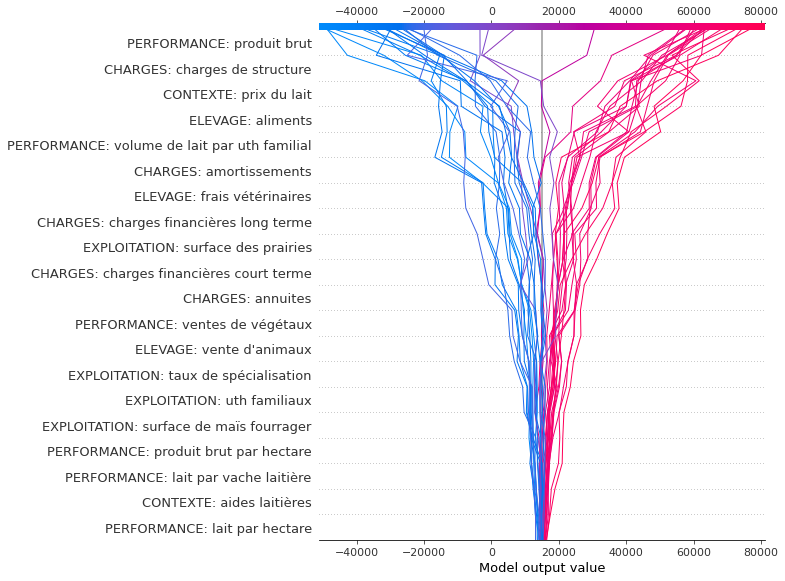

In [ ]:
bestandworst(1)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


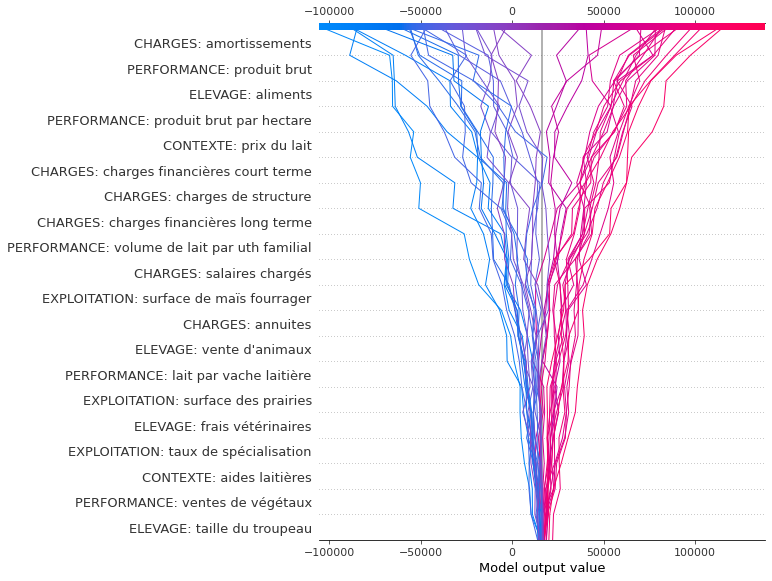

In [ ]:
bestandworst(2)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


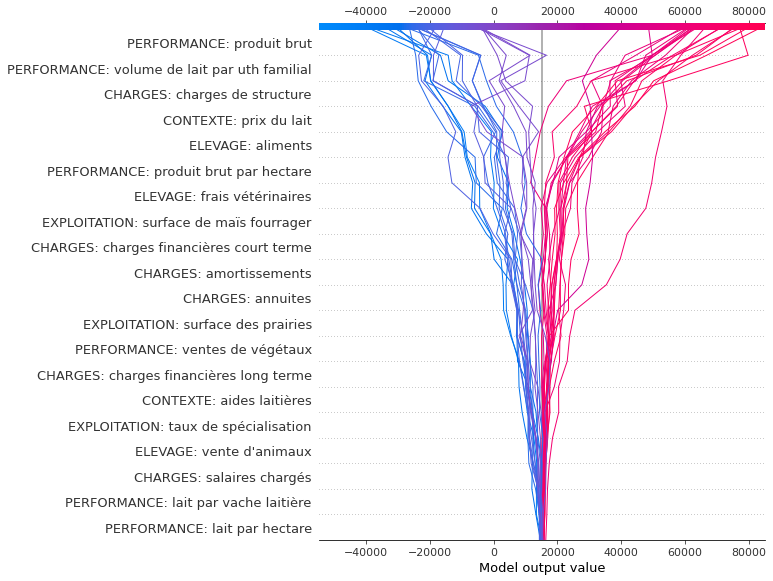

In [ ]:
bestandworst(3)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


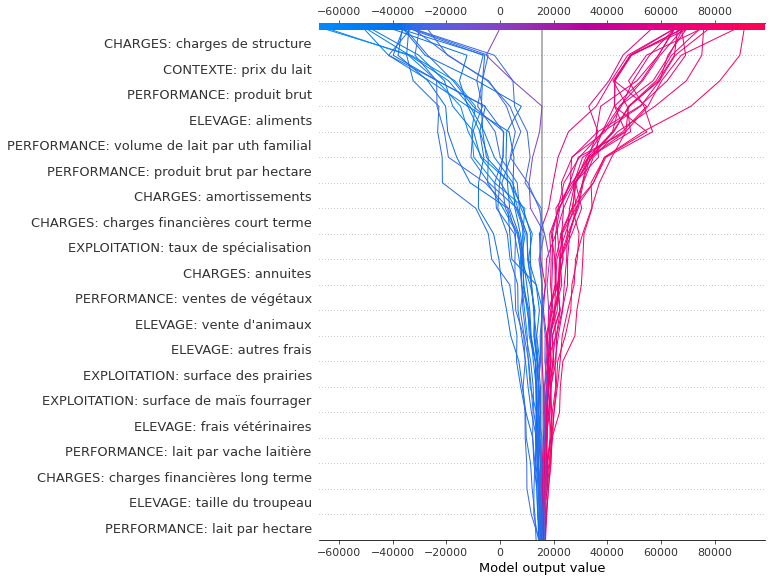

In [ ]:
bestandworst(4)

In [ ]:
from sklearn.neighbors import NearestNeighbors
X=dfclustered.set_index(['ID: département', 'ID: dossier', 'ID: année']).drop(['x','y'],1)
nbrs = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [ ]:
indices=pd.DataFrame(indices)

In [ ]:
i=[]
for index,row in indices.iterrows():
  for j in row[1:]:
    i.append({'index':index,'neighbor':j})

In [ ]:
i=pd.DataFrame(i)

In [ ]:
neighbors=i.merge(dfclustered[['PERFORMANCE: resultat par uth familial']],left_on='neighbor', right_index=True)

In [ ]:
best=neighbors.merge(dfclustered, left_on='index', right_index=True).merge(dfclustered, left_on='neighbor', right_index=True, suffixes=('', '_target'))

In [ ]:
best=best[best["EXPLOITATION: uth familiaux"]==best["EXPLOITATION: uth familiaux_target"]]
best=best[(np.abs(best['EXPLOITATION: surface des prairies']-best['EXPLOITATION: surface des prairies_target'])/best['EXPLOITATION: surface des prairies_target'])<0.1]
best=best[(np.abs(best['CHARGES: amortissements']-best['CHARGES: amortissements_target'])/best['CHARGES: amortissements_target'])<0.2]

In [ ]:
best

,index,neighbor,ID: département,ID: dossier,ID: année,EXPLOITATION: uth familiaux,EXPLOITATION: taux de spécialisation,EXPLOITATION: surface des prairies,EXPLOITATION: surface de maïs fourrager,ELEVAGE: autres frais,ELEVAGE: frais vétérinaires,ELEVAGE: aliments,ELEVAGE: taille du troupeau,ELEVAGE: vente d'animaux,CONTEXTE: prix du lait,CONTEXTE: aides laitières,CHARGES: annuites,CHARGES: amortissements,CHARGES: charges financières court terme,CHARGES: charges financières long terme,CHARGES: salaires chargés,CHARGES: charges de structure,PERFORMANCE: resultat par uth familial,PERFORMANCE: produit brut,PERFORMANCE: volume de lait par uth familial,PERFORMANCE: lait par vache laitière,PERFORMANCE: ventes de végétaux,PERFORMANCE: produit brut par hectare,PERFORMANCE: lait par hectare,x,y,cluster,ID: département_target,ID: dossier_target,ID: année_target,EXPLOITATION: uth familiaux_target,EXPLOITATION: taux de spécialisation_target,EXPLOITATION: surface des prairies_target,EXPLOITATION: surface de maïs fourrager_target,ELEVAGE: autres frais_target,...,ELEVAGE: taille du troupeau_delta,ELEVAGE: taille du troupeau_delta_perc,ELEVAGE: vente d'animaux_delta,ELEVAGE: vente d'animaux_delta_perc,CONTEXTE: prix du lait_delta,CONTEXTE: prix du lait_delta_perc,CONTEXTE: aides laitières_delta,CONTEXTE: aides laitières_delta_perc,CHARGES: annuites_delta,CHARGES: annuites_delta_perc,CHARGES: amortissements_delta,CHARGES: amortissements_delta_perc,CHARGES: charges financières court terme_delta,CHARGES: charges financières court terme_delta_perc,CHARGES: charges financières long terme_delta,CHARGES: charges financières long terme_delta_perc,CHARGES: salaires chargés_delta,CHARGES: salaires chargés_delta_perc,CHARGES: charges de structure_delta,CHARGES: charges de structure_delta_perc,PERFORMANCE: resultat par uth familial_delta,PERFORMANCE: resultat par uth familial_delta_perc,PERFORMANCE: produit brut_delta,PERFORMANCE: produit brut_delta_perc,PERFORMANCE: volume de lait par uth familial_delta,PERFORMANCE: volume de lait par uth familial_delta_perc,PERFORMANCE: lait par vache laitière_delta,PERFORMANCE: lait par vache laitière_delta_perc,PERFORMANCE: ventes de végétaux_delta,PERFORMANCE: ventes de végétaux_delta_perc,PERFORMANCE: produit brut par hectare_delta,PERFORMANCE: produit brut par hectare_delta_perc,PERFORMANCE: lait par hectare_delta,PERFORMANCE: lait par hectare_delta_perc,x_delta,x_delta_perc,y_delta,y_delta_perc,cluster_delta,cluster_delta_perc
0,1,326,52,26,2018,1.0,67.621396,65.92,0.00,1.868427,14.029173,81.226503,48.0,4600.92,348.651335,3.374485,49.373662,68.420362,0.000000,7.396953,0.000000,309.951123,11080.050,515.593224,170020.0000,3542.083333,0.136506,1329.811286,2579.186893,-57.111847,23.376852,3,52,26,2014,1.0,65.042207,61.03,17.15,1.631731,...,3.400000,0.070833,5008.97,1.088689,23.305535,0.066845,-3.374485,-1.000000,16.055833,0.325190,12.713732,0.185818,0.741716,inf,5.899620,0.797574,0.000000,NaN,37.392315,0.120639,1763.61000,0.159170,56.276776,0.109150,7258.0000,0.042689,-93.095006,-0.026283,0.009199,0.067387,201.376903,0.151433,98.324057,0.038122,0.538187,-0.009423,-0.110208,-0.004714,0,0.000000
1,4,3829,52,197,2018,3.0,77.652445,136.42,37.11,19.177456,38.261314,164.931999,197.6,103690.18,393.626872,0.000000,125.100625,116.990739,0.049770,8.787464,0.000000,353.004414,-24500.270,506.908537,191884.3333,2913.223684,-0.066845,1649.538836,3254.115319,-18.757664,55.689873,0,59,58312,2013,3.0,60.941229,126.22,36.60,14.513053,...,97.400000,0.492915,-30369.28,-0.292885,-33.237555,-0.084439,0.000000,NaN,12500.387955,99.922666,-4.475168,-0.038252,0.537246,10.794675,9.666107,1.099988,0.000000,NaN,-43.216700,-0.122425,44191.87333,-1.803730,84.463384,0.166625,18115.6667,0.094409,-777.630464,-0.266931,0.181445,-2.714430,964.764091,0.584869,1166.627085,0.358508,34.924116,-1.861858,0.196557,0.003529,0,NaN
6,16,401,52,3074,2018,1.0,53.295790,167.95,25.79,14.278439,19.045978,154.053185,231.8,53199.13,363.373210,0.000000,109.459461,127.59999

In [ ]:
best=best.groupby('index')['PERFORMANCE: resultat par uth familial_x'].max().reset_index().merge(best).drop_duplicates(subset='index')

In [ ]:
best=best.drop('PERFORMANCE: resultat par uth familial_x',1).rename(columns={'PERFORMANCE: resultat par uth familial':'PERFORMANCE: resultat par uth familial_target','PERFORMANCE: resultat par uth familial_y':'PERFORMANCE: resultat par uth familial'})

In [ ]:
for c in best.filter(regex='target').columns:
  c_init=c.replace('_target','')
  best[c_init+'_delta']=best[c]-best[c_init]
  best[c_init+'_delta_perc']=(best[c]-best[c_init])/best[c_init]

In [ ]:
best=best[best['PERFORMANCE: resultat par uth familial_delta']>0]

In [ ]:
best['PERFORMANCE: resultat par uth familial_delta_perc'].describe()

count    2720.000000
mean        0.611816
std        44.662710
min      -697.787674
25%         0.039457
50%         0.348343
75%         0.966615
max      1991.222222
Name: PERFORMANCE: resultat par uth familial_delta_perc, dtype: float64

In [ ]:
best[best['cluster']==0].cluster.value_counts().sort_index()

0    352
Name: cluster, dtype: int64

In [ ]:
best[best['cluster']==0].cluster_target.value_counts().sort_index()

0    293
1     21
2     19
3     15
4      4
Name: cluster_target, dtype: int64

In [ ]:
best.shape

(2720, 122)

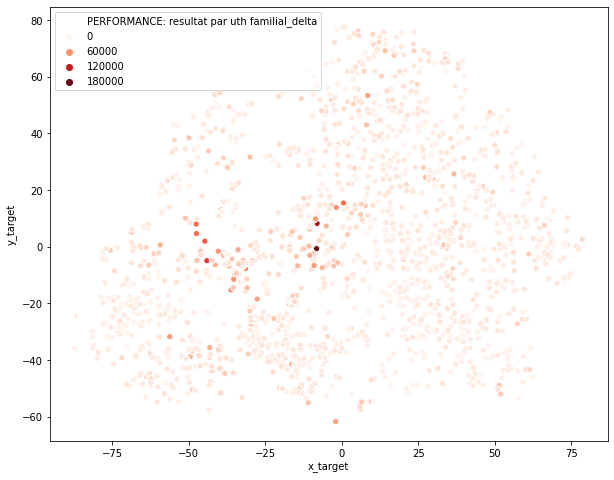

In [ ]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.scatterplot(data=best, x='x_target',y='y_target',hue='PERFORMANCE: resultat par uth familial_delta',ax=ax,palette="Reds",)

In [ ]:
best.groupby('cluster').mean().filter(regex='delta$')[['EXPLOITATION: uth familiaux_delta',
       'EXPLOITATION: taux de spécialisation_delta',
       'EXPLOITATION: surface des prairies_delta',
       'EXPLOITATION: surface de maïs fourrager_delta',
       'ELEVAGE: autres frais_delta', 'ELEVAGE: frais vétérinaires_delta',
       'ELEVAGE: aliments_delta', 'ELEVAGE: taille du troupeau_delta',
       'ELEVAGE: vente d\'animaux_delta', 'CONTEXTE: prix du lait_delta',
       'CONTEXTE: aides laitières_delta', 'CHARGES: annuites_delta',
       'CHARGES: amortissements_delta',
       'CHARGES: charges financières court terme_delta',
       'CHARGES: charges financières long terme_delta',
       'CHARGES: salaires chargés_delta',
       'CHARGES: charges de structure_delta',
       'PERFORMANCE: resultat par uth familial_delta',
       'PERFORMANCE: produit brut_delta',
       'PERFORMANCE: volume de lait par uth familial_delta',
       'PERFORMANCE: lait par vache laitière_delta']]

,EXPLOITATION: uth familiaux_delta,EXPLOITATION: taux de spécialisation_delta,EXPLOITATION: surface des prairies_delta,EXPLOITATION: surface de maïs fourrager_delta,ELEVAGE: autres frais_delta,ELEVAGE: frais vétérinaires_delta,ELEVAGE: aliments_delta,ELEVAGE: taille du troupeau_delta,ELEVAGE: vente d'animaux_delta,CONTEXTE: prix du lait_delta,CONTEXTE: aides laitières_delta,CHARGES: annuites_delta,CHARGES: amortissements_delta,CHARGES: charges financières court terme_delta,CHARGES: charges financières long terme_delta,CHARGES: salaires chargés_delta,CHARGES: charges de structure_delta,PERFORMANCE: resultat par uth familial_delta,PERFORMANCE: produit brut_delta,PERFORMANCE: volume de lait par uth familial_delta,PERFORMANCE: lait par vache laitière_delta
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.611961,0.213907,-0.418153,-0.148254,-1.979748,-9.911133,-6.076618,-7387.447614,15.594004,-1.016821,-100.833356,0.301685,-0.147740,-0.140159,0.372903,-2.466555,13469.271253,19.913700,-945.571152,126.218266
1,0.0,-0.097892,0.197494,-0.312551,-0.006810,-2.059437,-10.688525,-7.026496,-772.661305,-0.836967,-0.669567,-1892.002335,-0.838620,-0.426694,-2.482201,0.195202,-9.111971,9837.918159,0.843638,-22.886739,371.521061
2,0.0,1.240662,-0.091768,-2.169483,0.174957,0.241103,-0.953933,0.139220,-691.702584,10.421799,0.518294,998.754296,-0.204379,-0.634491,1.651474,-20.159266,-14.462089,24035.006840,6.925916,-9006.952950,14.374983
3,0.0,-3.266214,0.023126,1.725213,0.116173,0.201488,1.256734,-2.370804,1069.132570,24.594180,0.042817,-351.033922,1.561698,0.147818,0.822007,3.838692,14.006508,9957.997297,67.364382,-320.843916,241.416112
4,0.0,1.056531,0.335556,-1.406925,-1.402660,0.732868,-3.414650,22.618598,-160.260732,15.560589,1.260621,2303.439254,0.374798,-1.939532,-1.004944,1.890336,-13.704574,12528.793117,17.329239,-751.045654,-1267.350469


In [ ]:
best['PERFORMANCE: resultat par uth familial'].describe()

count      2720.000000
mean      11551.292571
std       19473.218667
min     -127695.000000
25%        1719.932500
50%       11476.827500
75%       22417.882500
max       83612.000000
Name: PERFORMANCE: resultat par uth familial, dtype: float64

In [ ]:
best['PERFORMANCE: resultat par uth familial_target'].describe()

count      2720.000000
mean      24388.230146
std       18212.178399
min      -40881.000000
25%       12724.400000
50%       21287.600000
75%       33780.118750
max      124937.690000
Name: PERFORMANCE: resultat par uth familial_target, dtype: float64

In [ ]:
resume=best.groupby('cluster').mean().filter(regex='perc$')

In [ ]:
resume[np.abs(resume)>0.05]

,ID: département_delta_perc,ID: dossier_delta_perc,ID: année_delta_perc,EXPLOITATION: uth familiaux_delta_perc,EXPLOITATION: taux de spécialisation_delta_perc,EXPLOITATION: surface des prairies_delta_perc,EXPLOITATION: surface de maïs fourrager_delta_perc,ELEVAGE: autres frais_delta_perc,ELEVAGE: frais vétérinaires_delta_perc,ELEVAGE: aliments_delta_perc,ELEVAGE: taille du troupeau_delta_perc,ELEVAGE: vente d'animaux_delta_perc,CONTEXTE: prix du lait_delta_perc,CONTEXTE: aides laitières_delta_perc,CHARGES: annuites_delta_perc,CHARGES: amortissements_delta_perc,CHARGES: charges financières court terme_delta_perc,CHARGES: charges financières long terme_delta_perc,CHARGES: salaires chargés_delta_perc,CHARGES: charges de structure_delta_perc,PERFORMANCE: resultat par uth familial_delta_perc,PERFORMANCE: produit brut_delta_perc,PERFORMANCE: volume de lait par uth familial_delta_perc,PERFORMANCE: lait par vache laitière_delta_perc,PERFORMANCE: ventes de végétaux_delta_perc,PERFORMANCE: produit brut par hectare_delta_perc,PERFORMANCE: lait par hectare_delta_perc,x_delta_perc,y_delta_perc,cluster_delta_perc
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,81.099310,NaN,NaN,NaN,NaN,inf,0.102069,NaN,NaN,NaN,-0.055279,0.057846,NaN,4.976979,NaN,inf,0.128767,inf,NaN,1.403059,NaN,NaN,0.085270,0.529371,NaN,NaN,-1.541549,-0.071780,inf
1,NaN,2422.466422,NaN,NaN,NaN,NaN,inf,NaN,0.057357,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,inf,NaN,-0.138636,NaN,NaN,0.139547,0.131731,NaN,NaN,-0.175887,-0.751737,0.725806
2,0.175066,13548.814923,NaN,NaN,NaN,NaN,inf,0.063681,0.163487,NaN,0.065289,inf,NaN,NaN,inf,NaN,inf,inf,inf,NaN,3.050491,NaN,NaN,0.062398,0.078756,0.078258,0.076060,-0.178003,-1.859503,0.074935
3,NaN,12247.547980,NaN,NaN,NaN,NaN,inf,NaN,0.218567,0.09583,NaN,inf,0.086843,NaN,inf,NaN,NaN,inf,inf,0.06931,-0.361381,0.147427,NaN,0.097661,0.670651,0.063963,-0.057176,-0.425614,0.265344,-0.173366
4,NaN,7907.759858,NaN,NaN,NaN,NaN,NaN,NaN,0.189210,NaN,0.393117,inf,0.052979,NaN,inf,NaN,inf,inf,inf,NaN,0.797002,NaN,NaN,-0.162565,0.052137,0.121744,0.100921,-0.058954,-0.586869,-0.247385


ERROR! Session/line number was not unique in database. History logging moved to new session 64


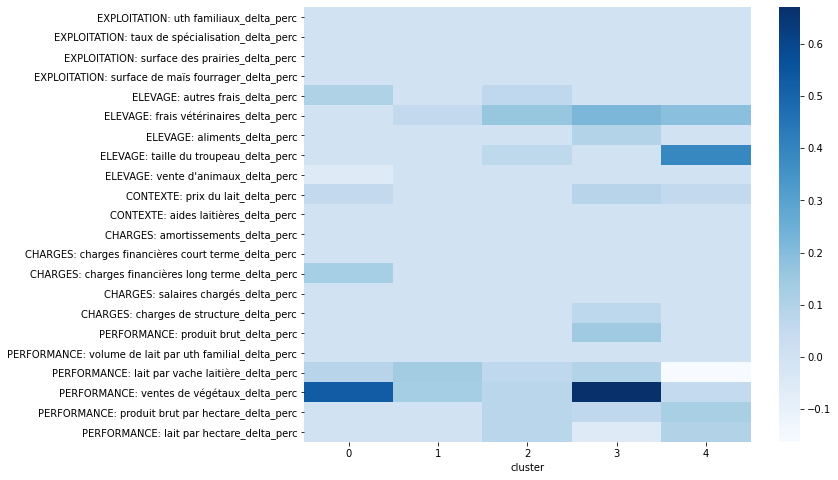

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
vals=resume[np.abs(resume)>0.05].T.fillna(0).replace(np.inf,0).iloc[3:-3,:] 
sns.heatmap(vals.drop(['CHARGES: annuites_delta_perc','PERFORMANCE: resultat par uth familial_delta_perc']), cmap='Blues',ax=ax)

cluster,0,1,2,3,4
EXPLOITATION: uth familiaux_delta_perc,0.000000,0.000000,0.000000,0.000000,0.000000
EXPLOITATION: taux de spécialisation_delta_perc,0.000000,0.000000,0.000000,0.000000,0.000000
EXPLOITATION: surface des prairies_delta_perc,0.000000,0.000000,0.000000,0.000000,0.000000
EXPLOITATION: surface de maïs fourrager_delta_perc,0.000000,0.000000,0.000000,0.000000,0.000000
ELEVAGE: autres frais_delta_perc,0.102069,0.000000,0.063681,0.000000,0.000000
ELEVAGE: frais vétérinaires_delta_perc,0.000000,0.057357,0.163487,0.218567,0.189210
ELEVAGE: aliments_delta_perc,0.000000,0.000000,0.000000,0.095830,0.000000
ELEVAGE: taille du troupeau_delta_perc,0.000000,0.000000,0.065289,0.000000,0.393117
ELEVAGE: vente d'animaux_delta_perc,-0.055279,0.000000,0.000000,0.000000,0.000000
CONTEXTE: prix du lait_delta_perc,0.057846,0.000000,0.000000,0.086843,0.052979


In [ ]:
dfshort[target]=np.where(
    dfscaled[target]<dfscaled[target].mean()-dfscaled[target].std(),-2,
    np.where(dfscaled[target]<dfscaled[target].mean(),-1,
             np.where(dfscaled[target]<dfscaled[target].mean()+dfscaled[target].std(),1,2)))
fig, ax = plt.subplots(figsize=(10,8)) 
sns.scatterplot(data=dfshort, x='x',y='y',hue=target,ax=ax,palette="Reds",)

NameError: ignored

In [ ]:
import xgboost,shap
def importance(X,y):
  model = xgboost.train({"learning_rate": 0.01,"objective": 'multi:softmax','num_class':n_clusters}, xgboost.DMatrix(X, label=y), 100)
  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X)
  shap.initjs()
  shap.summary_plot(shap_values, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


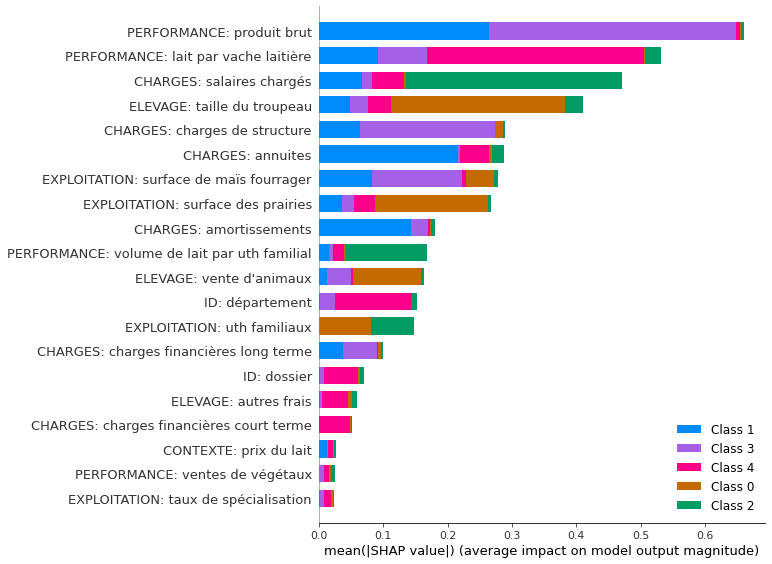

In [ ]:
importance(df.drop(target,1),y)

In [ ]:
centers = pd.DataFrame(km.cluster_centers_, columns=dfscaled.drop(target,1).columns)

In [ ]:
dfscaledwithcluster=dfscaled
dfscaledwithcluster['cluster']=y

In [ ]:
dfscaledwithcluster=dfscaledwithcluster.groupby('cluster').mean()

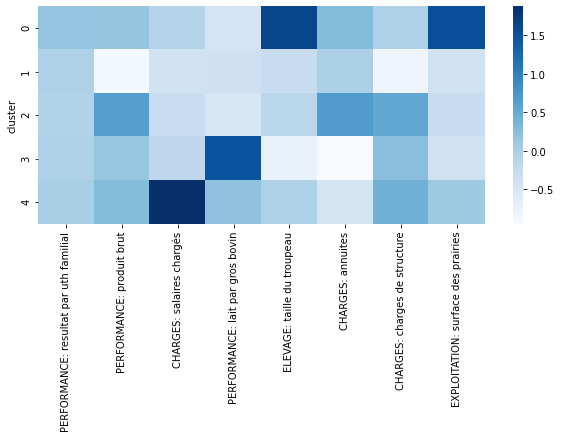

In [ ]:
fig, ax = plt.subplots(figsize=(10,4)) 
sns.heatmap(dfscaledwithcluster[[target,'PERFORMANCE: produit brut','CHARGES: salaires chargés','PERFORMANCE: lait par gros bovin','ELEVAGE: taille du troupeau','CHARGES: annuites','CHARGES: charges de structure','EXPLOITATION: surface des prairies']],ax=ax,cmap="Blues")

In [ ]:
X=df.drop([target,'ID: dossier','ID: département'],1)
y=df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model=lgb.LGBMRegressor()
model.fit(X_train,y_train, eval_set=(X_test,y_test), verbose=False)
print(mean_absolute_error(y_test, model.predict(X_test)))
lgb.plot_importance(model, max_num_features=40, figsize=(12,12))

NameError: ignored

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


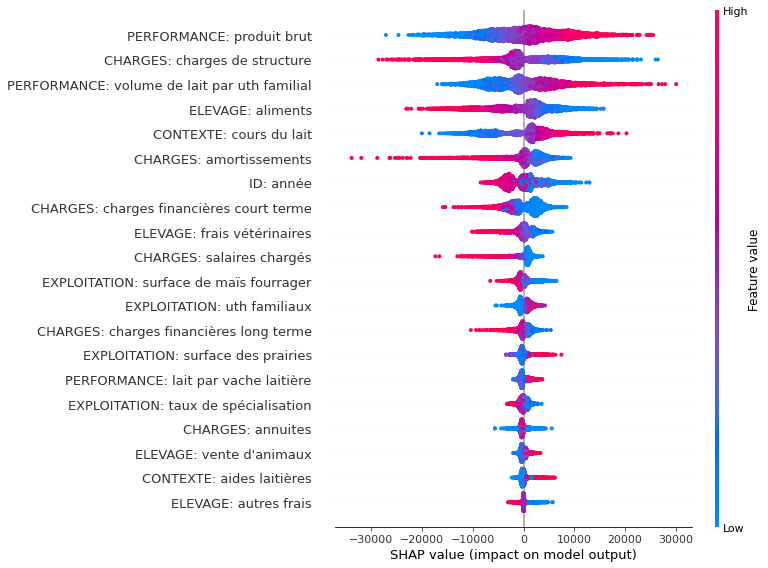

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.initjs()
shap.summary_plot(shap_values, X)

#optimisations

In [ ]:
dfclustered=pd.read_csv('gs://referentiels2/dfclustered.csv')

In [ ]:
#passer les colonnes de positionnements en pratiques d'élevages
dfclustered=dfclustered.rename(columns={'POSITIONNEMENT: lait par vache laitière':'PRATIQUES D\'ELEVAGE: lait par vache laitière',
       'POSITIONNEMENT: lait par ha de surface fourragère principale':'PRATIQUES D\'ELEVAGE: lait par ha de surface fourragère principale'})
#création du modèle de prédiction de cible
import lightgbm as lgb
random_state = 7
X = dfclustered.drop(['CIBLE: resultat par uth familial','cluster','ID: département','ID: dossier'],1)
y=dfclustered['CIBLE: resultat par uth familial']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
model=lgb.LGBMRegressor(n_estimators=50000)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20,verbose=False)
model.score(X_test,y_test)
#création du modèle de cluster
X = dfclustered[['PRATIQUES D\'ELEVAGE: lait par vache laitière','PRATIQUES D\'ELEVAGE: lait par ha de surface fourragère principale']]
y=dfclustered['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
modelcluster=lgb.LGBMClassifier(n_estimators=50000)
modelcluster.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20,verbose=False)
modelcluster.score(X_test,y_test)

0.972972972972973

In [ ]:
import joblib
joblib.dump(model,'model')
joblib.dump(modelcluster,'modelcluster')

['modelcluster']

In [ ]:
!gsutil cp model gs://referentiels2/
!gsutil cp modelcluster gs://referentiels2/


Copying file://model [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/279.6 KiB.                                    
Copying file://modelcluster [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/978.1 KiB.                                    


In [ ]:
!gsutil -m rm -r gs://referentiels2/cerfrance*.csv

In [ ]:
dfclustered[[]].to_csv('gs://findstorage/cerfrance/simulation7.csv',index=True)

In [ ]:
!gsutil -m cp -r gs://referentiels2/cerfrance*.csv .

In [ ]:
import os
files=[f for f in os.listdir() if '.csv' in f]

In [ ]:
simulation=[]
for f in files:
  try:
    simulation.append(pd.read_csv(f) )
  except:
    print('error for '+f)

In [ ]:
simulation=pd.concat(simulation)

In [ ]:
simulation=simulation.dropna()

In [ ]:
simulation['index']=simulation['index'].astype(int)

In [ ]:
simulation.head()

,INVARIANT: prix du lait,DIMENSION: uth familiaux,DIMENSION: surface des prairies,DIMENSION: taille du troupeau,DIMENSION: surface de maïs fourrager,DYNAMIQUE STRUCTURELLE: annuites,DYNAMIQUE STRUCTURELLE: amortissements,DYNAMIQUE STRUCTURELLE: charges financières court terme,DYNAMIQUE STRUCTURELLE: charges financières long terme,DYNAMIQUE STRUCTURELLE: salaires chargés,DYNAMIQUE STRUCTURELLE: volume de lait par uth familial,DYNAMIQUE STRUCTURELLE: charges de structure,PRATIQUES D'ELEVAGE: produit brut,PRATIQUES D'ELEVAGE: autres frais,PRATIQUES D'ELEVAGE: frais vétérinaires,PRATIQUES D'ELEVAGE: aliments,PRATIQUES D'ELEVAGE: taux de spécialisation,PRATIQUES D'ELEVAGE: vente d'animaux,PRATIQUES D'ELEVAGE: ventes de végétaux,PRATIQUES D'ELEVAGE: produit brut par hectare,PRATIQUES D'ELEVAGE: lait par ha de surface fourragère principale,PRATIQUES D'ELEVAGE: lait par vache laitière,index,colonnes,cluster,CIBLE: resultat par uth familial
0,381.131548,1.000000,46.260000,71.500000,18.400000,105.183855,123.276493,8.929742,28.126940,0.000000,343123.000000,288.255301,637.123843,14.519615,16.161122,107.837307,57.665249,19028.521744,0.151320,2428.437087,5044.061750,4302.080722,120,PRATIQUES D'ELEVAGE,1.0,16873.477894
1,381.131548,1.000000,46.260000,71.500000,18.400000,105.554464,69.800815,0.842134,7.144398,0.623266,332838.610347,288.370122,526.609991,14.519615,17.501124,110.072136,72.374538,7889.340000,0.122480,3085.587432,7417.271941,4798.923077,120,DYNAMIQUE STRUCTURELLE,1.0,22907.541574
2,381.131548,1.464480,78.393450,87.734247,9.976728,105.183855,123.276493,8.929742,28.126940,0.000000,343123.000000,288.255301,526.609991,14.519615,17.501124,110.072136,72.374538,7889.340000,0.122480,3085.587432,7417.271941,4798.923077,120,DIMENSION,1.0,8751.952641
3,381.131548,1.034955,73.469825,87.546681,10.563953,94.074974,69.360188,0.548566,7.723715,9.637739,360934.712043,290.083068,630.986599,14.519615,15.845395,101.492718,63.956975,33132.226629,0.129487,2872.235512,4832.776062,4203.307797,120,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIM...,1.0,53539.290559
4,381.131548,1.665424,50.802575,103.389522,20.916400,85.511649,69.025846,2.277928,9.928680,1.444044,458848.684934,259.136124,615.404179,16.546506,15.877855,100.747027,54.637522,35560.498749,0.250978,4019.013960,16598.842323,8030.182021,120,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIM...,0.0,74797.225721


In [ ]:
simulationresults=dfclustered.merge(simulation, left_index=True, right_on=['index']).drop('index',1)

In [ ]:
effort=np.abs((simulationresults.filter(regex='_y').drop(['cluster_y','CIBLE: resultat par uth familial_y'],1).values-simulationresults.filter(regex='_x').drop(['cluster_x','CIBLE: resultat par uth familial_x'],1).values)/simulationresults.filter(regex='_x').drop(['cluster_x','CIBLE: resultat par uth familial_x'],1).values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
effort=pd.DataFrame(effort).replace(np.inf,0).mean(1)

In [ ]:
simulationresults['effort']=effort

In [ ]:
simulationresults['gain']=simulationresults['CIBLE: resultat par uth familial_y']-simulationresults['CIBLE: resultat par uth familial_x']
simulationresults['gainrelatif']=(simulationresults['CIBLE: resultat par uth familial_y']-simulationresults['CIBLE: resultat par uth familial_x'])/simulationresults['CIBLE: resultat par uth familial_x']

In [ ]:
simulationresults['interessant']=(simulationresults['gain']>0) & (simulationresults['effort']<1)

In [ ]:
final=simulationresults[simulationresults['interessant']==True].groupby(['cluster_x','cluster_y','colonnes'])['effort','gain'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
final['rentabilite']=final.gain/final.effort

In [ ]:
final.sort_values(by='rentabilite',ascending=False)

,,,effort,gain,rentabilite
cluster_x,cluster_y,colonnes,,,
3,0.0,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION,0.372507,51453.816350,138128.509289
2,0.0,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION,0.370940,51219.277318,138079.727000
0,0.0,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION,0.374693,50660.185146,135204.678236
1,0.0,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION,0.374800,50352.977798,134346.173270
4,0.0,PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION,0.376053,47421.467900,126103.095720
...,...,...,...,...,...
3,4.0,DIMENSION,0.810882,13662.454913,16848.882262
0,0.0,DIMENSION,0.810882,13169.027780,16240.375539
4,2.0,DIMENSION,0.810882,12600.021067,15538.662181


In [ ]:
simulationresults.to_csv('gs://referentiels2/simulationresults.csv',index=False)

In [ ]:
simulationresults=pd.read_csv('gs://referentiels2/simulationresults.csv')

In [ ]:
simulationresults.head(n=10)

In [ ]:
simulationresults['gain'].describe()

count     5888.000000
mean     26447.590660
std      22974.509637
min     -91681.801779
25%      12324.821954
50%      28608.246258
75%      42329.914540
max      97848.052595
Name: gain, dtype: float64

In [ ]:
simulationresults.groupby(['cluster_x','colonnes']).gain.median()

cluster_x  colonnes                                            
0          DIMENSION                                                3209.240062
           DYNAMIQUE STRUCTURELLE                                  23770.533950
           PRATIQUES D'ELEVAGE                                     15571.682473
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    36340.313464
1          DIMENSION                                                  97.368301
           DYNAMIQUE STRUCTURELLE                                  19731.326478
           PRATIQUES D'ELEVAGE                                      8730.029855
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    35130.842281
2          DIMENSION                                                 524.039494
           DYNAMIQUE STRUCTURELLE                                  22640.993967
           PRATIQUES D'ELEVAGE                                      9160.177641
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DI

In [ ]:
simulationresults[simulationresults.cluster_x==simulationresults.cluster_y].groupby(['cluster_x','colonnes']).gainrelatif.median()

cluster_x  colonnes                                            
0          DIMENSION                                              -2.316483
           DYNAMIQUE STRUCTURELLE                                  1.587711
           PRATIQUES D'ELEVAGE                                    -0.477044
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    2.904561
1          DIMENSION                                              -0.058368
           DYNAMIQUE STRUCTURELLE                                  0.893529
           PRATIQUES D'ELEVAGE                                    -0.019812
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    1.228751
2          DIMENSION                                               0.028035
           DYNAMIQUE STRUCTURELLE                                  1.668029
           PRATIQUES D'ELEVAGE                                     0.406944
           PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    2.139080
3          DIMENSION    

In [ ]:
simulationresults[simulationresults.cluster_x!=simulationresults.cluster_y].groupby(['cluster_x','cluster_y']).gainrelatif.median()

cluster_x  cluster_y
0          1.0          1.139378
           2.0          2.013433
           3.0          1.854827
           4.0          1.246988
1          0.0          2.257614
           2.0          1.362406
           3.0          1.099588
           4.0          0.943944
2          0.0          2.961965
           1.0          1.030588
           3.0          1.699511
           4.0          1.083293
3          0.0          2.886253
           1.0          0.828233
           2.0          1.610860
           4.0          0.656163
4          0.0          1.932008
           1.0          0.586566
           2.0          1.227664
           3.0          1.080615
Name: gainrelatif, dtype: float64

In [ ]:
simulationresults.colonnes.value_counts()

PRATIQUES D'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION    3680
PRATIQUES D'ELEVAGE                                      736
DIMENSION                                                736
DYNAMIQUE STRUCTURELLE                                   736
Name: colonnes, dtype: int64

In [ ]:
import plotly.graph_objects as go
colonnes='DIMENSION'#'DYNAMIQUE_STRUCTURELLE'
values=simulationresults[simulationresults['colonnes']==colonnes].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
colonnes='DYNAMIQUE STRUCTURELLE'
values=simulationresults[simulationresults['colonnes']==colonnes].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
import plotly.graph_objects as go
colonnes='PRATIQUES D\'ELEVAGE'
values=simulationresults[simulationresults['colonnes']==colonnes].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
colonnes='PRATIQUES D\'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION'
values=simulationresults[(simulationresults.cluster_x==simulationresults.cluster_y) & (simulationresults['colonnes']==colonnes)].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
simulationresults[simulationresults.cluster_x!=simulationresults.cluster_y].cluster_y.value_counts()

4.0    1611
1.0    1220
3.0     868
2.0     660
0.0     523
Name: cluster_y, dtype: int64

In [ ]:
colonnes='PRATIQUES D\'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION'
values=simulationresults[(simulationresults.cluster_x!=simulationresults.cluster_y) & (simulationresults['colonnes']==colonnes)].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()
values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
colonnes='PRATIQUES D\'ELEVAGE|DYNAMIQUE STRUCTURELLE|DIMENSION'
values=simulationresults[(simulationresults.cluster_y==1) & (simulationresults.cluster_x!=simulationresults.cluster_y) & (simulationresults['colonnes']==colonnes)].drop(['ID: dossier','ID: département'],1).filter(regex='_y').groupby('cluster_y').mean()

values=pd.DataFrame(MinMaxScaler().fit_transform(values),columns=values.columns)

categories = values.columns
for index, row in values.iterrows():
  fig = go.Figure()
  fig.add_trace(go.Scatterpolar(
        r=list(row.values),
        theta=categories,
        fill='toself',
        name=str(index),
        line_color='rgb'+str(sns.color_palette("Set2",8)[index])
  ))
  fig.show()

In [ ]:
delta=simulationresults.filter(regex='_y').values-simulationresults.filter(regex='_x').values
deltarelatif=(simulationresults.filter(regex='_y').values-simulationresults.filter(regex='_x').values)/simulationresults.filter(regex='_x').values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



In [ ]:
delta.shape

(5888, 21)

In [ ]:
deltarelatif.shape

(5888, 21)

In [ ]:
simulationresults.shape

(5888, 52)

In [ ]:
delta=pd.DataFrame(delta, columns=[c.replace('_y','_delta') for c in simulationresults.filter(regex='_y').columns],index=simulationresults.index)
deltarelatif=pd.DataFrame(deltarelatif, columns=[c.replace('_y','_deltarelatif') for c in simulationresults.filter(regex='_y').columns],index=simulationresults.index)

In [ ]:
simulationresults=pd.concat([simulationresults,delta,deltarelatif],1).drop(['CIBLE: resultat par uth familial_deltarelatif','cluster_deltarelatif'],1)

In [ ]:
simulationresults

In [ ]:
simulationresults.to_csv('gs://referentiels2/simulationresults.csv',index=False, sep=';')

In [ ]:
simulationresults.to_csv('simulationresults.csv',index=False, sep=';')

In [ ]:
import pandas as pd, numpy as np

In [ ]:
!pip install -q gcsfs

In [ ]:
s=pd.read_csv('gs://referentiels2/simulationresults.csv', sep=';')

In [ ]:
s['Objectifs en productivité L / UTH Fam']=np.where((s.gain>0) & (s['DYNAMIQUE STRUCTURELLE: volume de lait par uth familial_delta']<-30), 'Réduire le volume lait /UTH de '+s['DYNAMIQUE STRUCTURELLE: volume de lait par uth familial_delta'].astype(int).astype(str)+' l',
  np.where((s.gain>0) & (s['DYNAMIQUE STRUCTURELLE: volume de lait par uth familial_delta']>30), 'Augmenter le volume lait /UTH de '+s['DYNAMIQUE STRUCTURELLE: volume de lait par uth familial_delta'].astype(int).astype(str)+' l',np.NaN))
limite=200
objectif='Productivité L / ha SFP'
colonne="PRATIQUES D'ELEVAGE: lait par ha de surface fourragère principale_delta"
s['Objectifs en '+objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Réduire la '+objectif+' de '+s[colonne].astype(int).astype(str)+' l',
  np.where((s.gain>0) & (s[colonne]>limite), 'Augmenter la '+objectif+' de '+s[colonne].astype(int).astype(str)+' l',''))
limite = 100
objectif='Productivité L / VL'
colonne="PRATIQUES D'ELEVAGE: lait par vache laitière_delta"
s['Objectifs en '+objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Réduire la '+objectif+' de '+s[colonne].astype(int).astype(str)+' l',
  np.where((s.gain>0) & (s[colonne]>limite), 'Augmenter la '+objectif+' de '+s[colonne].astype(int).astype(str)+' l',''))
objectif='INVESTIR'
colonne='DYNAMIQUE STRUCTURELLE: amortissements_delta'
s[objectif]=np.where((s.gain>0) & (s[colonne]<=-10), 'Réduire les investissements',
  np.where((s.gain>0) & (s[colonne]<=-5), 'Freiner les investissements',
           np.where((s.gain>0) & (s[colonne]>=10), 'Investir',
                    np.where((s.gain>0) & (s[colonne]>=5), 'Investir un peu plus',''))))
objectif="MAIN D'ŒUVRE SALARIEE"
limite = 5
colonne="DYNAMIQUE STRUCTURELLE: salaires chargés_delta"
s[objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Réduire la MO salariée',
  np.where((s.gain>0) & (s[colonne]>limite), 'Embaucher',''))
objectif="COUT ALIMENTAIRE"
limite = 0
colonne="PRATIQUES D'ELEVAGE: aliments_delta"
s[objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Baisser coût alimentaire',
  np.where((s.gain>0) & (s[colonne]>limite), 'Augmenter coût alimentaire',''))
objectif="Surf prairies"
limite = 0
colonne="DIMENSION: surface des prairies_delta"
s[objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Baisser',
  np.where((s.gain>0) & (s[colonne]>limite), 'Augmenter',''))
objectif="Surf maïs"
limite = 0
colonne="DIMENSION: surface de maïs fourrager_delta"
s[objectif]=np.where((s.gain>0) & (s[colonne]<-limite), 'Baisser',
  np.where((s.gain>0) & (s[colonne]>limite), 'Augmenter',''))
s.columns=[c.replace(': ','_').replace(' ','_').replace("'",'_').replace('é','e').replace('ï','i').replace('è','e').replace('/','par').replace('Œ','oe') for c in s.columns]

In [ ]:
s.to_gbq('cerfrance.lait', project_id='tinbiwebsite', if_exists='replace')

1it [00:12, 12.66s/it]


In [ ]:
s.query('ID_dossier=="2090"')

,ID_departement,ID_dossier,INVARIANT_prix_du_lait_x,DIMENSION_uth_familiaux_x,DIMENSION_surface_des_prairies_x,DIMENSION_taille_du_troupeau_x,DIMENSION_surface_de_mais_fourrager_x,DYNAMIQUE_STRUCTURELLE_annuites_x,DYNAMIQUE_STRUCTURELLE_amortissements_x,DYNAMIQUE_STRUCTURELLE_charges_financieres_court_terme_x,DYNAMIQUE_STRUCTURELLE_charges_financieres_long_terme_x,DYNAMIQUE_STRUCTURELLE_salaires_charges_x,DYNAMIQUE_STRUCTURELLE_volume_de_lait_par_uth_familial_x,DYNAMIQUE_STRUCTURELLE_charges_de_structure_x,PRATIQUES_D_ELEVAGE_produit_brut_x,PRATIQUES_D_ELEVAGE_autres_frais_x,PRATIQUES_D_ELEVAGE_frais_veterinaires_x,PRATIQUES_D_ELEVAGE_aliments_x,PRATIQUES_D_ELEVAGE_taux_de_specialisation_x,PRATIQUES_D_ELEVAGE_lait_par_vache_laitiere_x,PRATIQUES_D_ELEVAGE_lait_par_ha_de_surface_fourragere_principale_x,CIBLE_resultat_par_uth_familial_x,cluster_x,INVARIANT_prix_du_lait_y,DIMENSION_uth_familiaux_y,DIMENSION_surface_des_prairies_y,DIMENSION_taille_du_troupeau_y,DIMENSION_surface_de_mais_fourrager_y,DYNAMIQUE_STRUCTURELLE_annuites_y,DYNAMIQUE_STRUCTURELLE_amortissements_y,DYNAMIQUE_STRUCTURELLE_charges_financieres_court_terme_y,DYNAMIQUE_STRUCTURELLE_charges_financieres_long_terme_y,DYNAMIQUE_STRUCTURELLE_salaires_charges_y,DYNAMIQUE_STRUCTURELLE_volume_de_lait_par_uth_familial_y,DYNAMIQUE_STRUCTURELLE_charges_de_structure_y,PRATIQUES_D_ELEVAGE_produit_brut_y,PRATIQUES_D_ELEVAGE_autres_frais_y,PRATIQUES_D_ELEVAGE_frais_veterinaires_y,PRATIQUES_D_ELEVAGE_aliments_y,PRATIQUES_D_ELEVAGE_taux_de_specialisation_y,...,DYNAMIQUE_STRUCTURELLE_charges_financieres_long_terme_delta,DYNAMIQUE_STRUCTURELLE_salaires_charges_delta,DYNAMIQUE_STRUCTURELLE_volume_de_lait_par_uth_familial_delta,DYNAMIQUE_STRUCTURELLE_charges_de_structure_delta,PRATIQUES_D_ELEVAGE_produit_brut_delta,PRATIQUES_D_ELEVAGE_autres_frais_delta,PRATIQUES_D_ELEVAGE_frais_veterinaires_delta,PRATIQUES_D_ELEVAGE_aliments_delta,PRATIQUES_D_ELEVAGE_taux_de_specialisation_delta,PRATIQUES_D_ELEVAGE_lait_par_ha_de_surface_fourragere_principale_delta,PRATIQUES_D_ELEVAGE_lait_par_vache_laitiere_delta,cluster_delta,CIBLE_resultat_par_uth_familial_delta,INVARIANT_prix_du_lait_deltarelatif,DIMENSION_uth_familiaux_deltarelatif,DIMENSION_surface_des_prairies_deltarelatif,DIMENSION_taille_du_troupeau_deltarelatif,DIMENSION_surface_de_mais_fourrager_deltarelatif,DYNAMIQUE_STRUCTURELLE_annuites_deltarelatif,DYNAMIQUE_STRUCTURELLE_amortissements_deltarelatif,DYNAMIQUE_STRUCTURELLE_charges_financieres_court_terme_deltarelatif,DYNAMIQUE_STRUCTURELLE_charges_financieres_long_terme_deltarelatif,DYNAMIQUE_STRUCTURELLE_salaires_charges_deltarelatif,DYNAMIQUE_STRUCTURELLE_volume_de_lait_par_uth_familial_deltarelatif,DYNAMIQUE_STRUCTURELLE_charges_de_structure_deltarelatif,PRATIQUES_D_ELEVAGE_produit_brut_deltarelatif,PRATIQUES_D_ELEVAGE_autres_frais_deltarelatif,PRATIQUES_D_ELEVAGE_frais_veterinaires_deltarelatif,PRATIQUES_D_ELEVAGE_aliments_deltarelatif,PRATIQUES_D_ELEVAGE_taux_de_specialisation_deltarelatif,PRATIQUES_D_ELEVAGE_lait_par_ha_de_surface_fourragere_principale_deltarelatif,PRATIQUES_D_ELEVAGE_lait_par_vache_laitiere_deltarelatif,Objectifs_en_productivite_L_par_UTH_Fam,Objectifs_en_Productivite_L_par_ha_SFP,Objectifs_en_Productivite_L_par_VL,INVESTIR,MAIN_D_oeUVRE_SALARIEE,COUT_ALIMENTAIRE,Surf_prairies,Surf_mais
296,52,2090,375.801194,2.6,152.318,131.16,0.0,71.427081,143.279449,0.0,3.925984,3.84603,266177.49998,311.914168,618.291231,11.024578,11.905744,101.75768,60.863423,5035.087161,4335.36602,38092.511334,0,367.202145,1.000000,71.640000,103.300000,19.760000,74.606751,108.702995,0.890025,2.234352,55.635870,592118.000000,288.255301,640.949577,14.519615,12.287014,93.717431,61.312815,...,-1.691632,51.789840,325940.500020,-23.658868,22.658347,3.495037,0.381271,-8.040248,0.449393,6040.507025,2616.440766,-38089.511334,67373.681071,-0.022882,-0.615385,-0.529668,-0.212412,inf,0.044516,-0.241322,inf,-0.430881,13.465791,1.224523,-0.075851,0.036647,0.317022,0.032024,-0.079014,0.007384,1.199683,0.603